Fetching market data...
Loading data for DE30_EUR (max 20000 candles)...
Successfully fetched 20000 candles from 2024-05-22 02:00:00+00:00 to 2025-05-09 19:00:00+00:00

Preparing technical features...

Creating clustered market states...

State profiles (average values):
         returns     rsi   natr  ma_crossover
State 0    0.023  72.517  0.263        30.251
State 1    0.038  28.186  0.800      -121.266
State 2   -0.005  35.912  0.252       -18.302
State 3    0.133  69.659  1.940       287.376
State 4   -0.458  25.198  0.418       -12.766


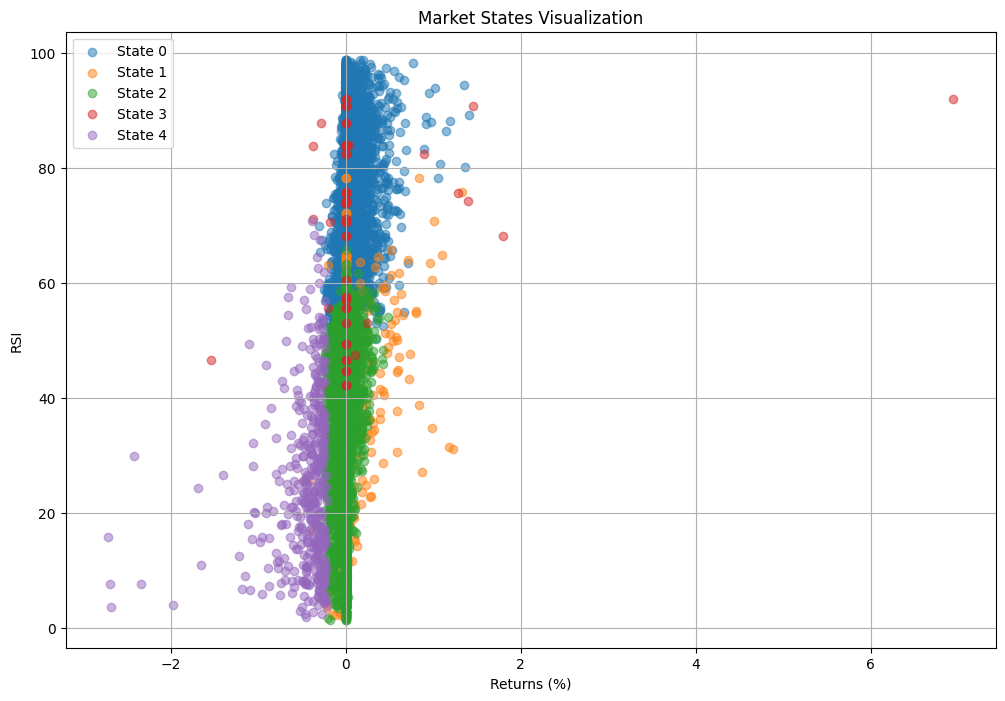


State interpretations:
State 0: Neutral
State 1: Buy
State 2: Sell
State 3: Strong Buy
State 4: Strong Sell

Building 3-order Markov model...
Learned transitions for 48 unique state sequences

Current Market State Sequence: Sell → Sell → Sell

Generating 5-step forecast with 3-order Markov model...

5-Step Forecast Probabilities:
   Neutral    Buy   Sell  Strong Buy  Strong Sell
1    0.070  0.002  0.899         0.0        0.030
2    0.118  0.005  0.853         0.0        0.024
3    0.160  0.008  0.810         0.0        0.022
4    0.204  0.014  0.758         0.0        0.024
5    0.239  0.017  0.720         0.0        0.024


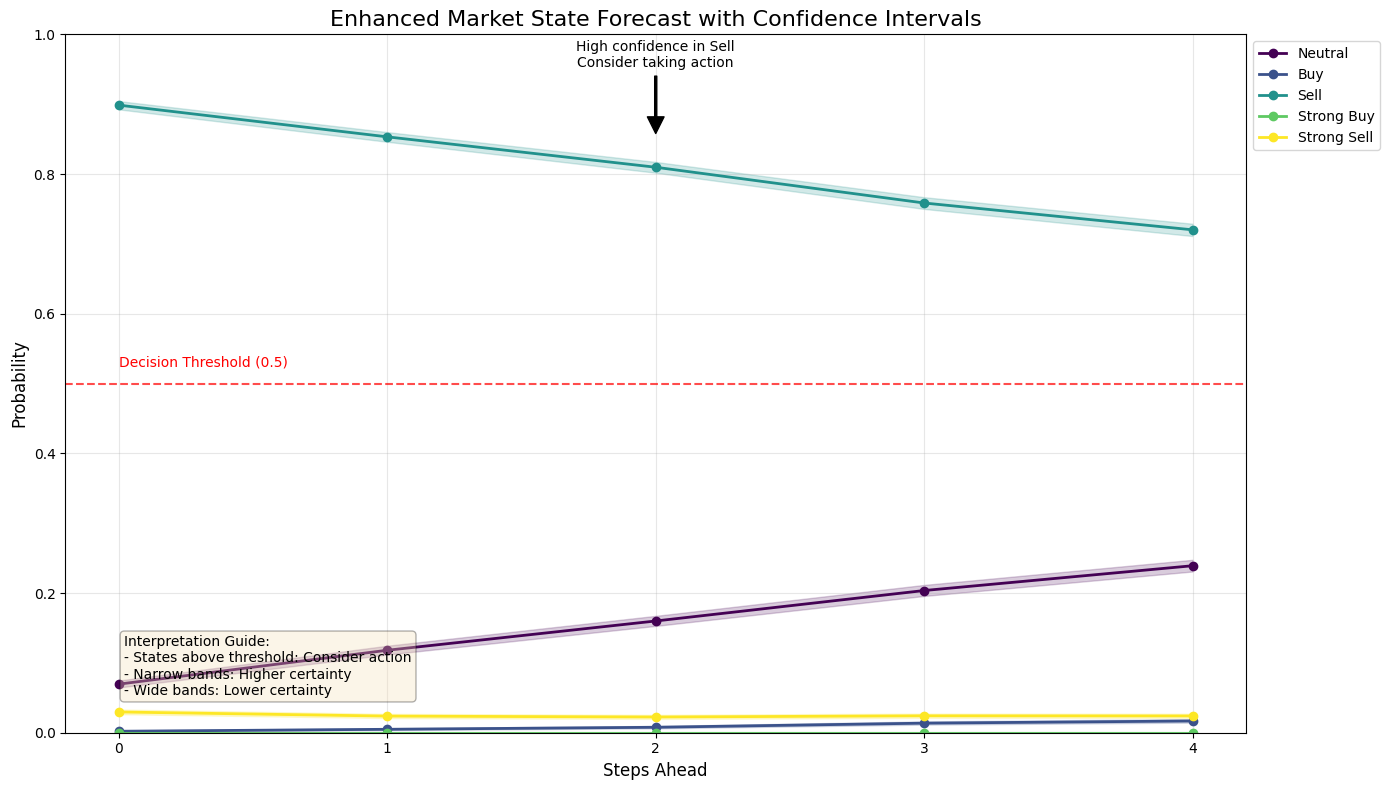

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
from datetime import datetime, timedelta
import time
import talib
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



def fetch_oanda_data_with_pagination(instrument, api_key, granularity="D", max_candles=5000):
    print(f"Loading data for {instrument} (max {max_candles} candles)...")
    api = oandapyV20.API(access_token=api_key)
    all_data = []
    count_per_request = min(5000, max_candles)

    params = {"granularity": granularity, "count": count_per_request}

    while len(all_data) < max_candles:
        try:
            r = instruments.InstrumentsCandles(instrument=instrument, params=params)
            response = api.request(r)
            new_data = response["candles"]
            if not new_data:
                break
            all_data.extend(new_data)
            if len(new_data) < count_per_request or len(all_data) >= max_candles:
                break
            oldest_time = pd.to_datetime(new_data[-1]['time'])
            params['to'] = (oldest_time - timedelta(seconds=1)).isoformat()
            params['count'] = min(count_per_request, max_candles - len(all_data))
            time.sleep(0.5)
        except Exception as e:
            print(f"Error fetching data chunk: {e}")
            break

    if not all_data:
        print(f"No data received for {instrument}.")
        return None

    # Create a DataFrame with OHLC data
    df = pd.DataFrame([{
        'time': candle['time'],
        'open': float(candle['mid']['o']),
        'high': float(candle['mid']['h']),
        'low': float(candle['mid']['l']),
        'close': float(candle['mid']['c']),
        'volume': int(candle['volume']) if 'volume' in candle else 0
    } for candle in all_data])

    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)
    print(f"Successfully fetched {len(df)} candles from {df.index[0]} to {df.index[-1]}")
    return df

def prepare_features(df):
    """Create a rich feature set for better state modeling"""
    features = df.copy()
    
    # Basic features
    features['returns'] = features['close'].pct_change() * 100  # Use percentage
    features['range'] = (features['high'] - features['low']) / features['close'] * 100
    
    # Technical indicators using TA-Lib
    # Momentum
    features['rsi'] = talib.RSI(features['close'].values, timeperiod=14)
    features['cci'] = talib.CCI(features['high'].values, features['low'].values, features['close'].values, timeperiod=14)
    
    # Trend
    features['macd'], features['macd_signal'], features['macd_hist'] = talib.MACD(
        features['close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
    features['slowk'], features['slowd'] = talib.STOCH(
        features['high'].values, features['low'].values, features['close'].values, 
        fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    
    # Volatility
    features['atr'] = talib.ATR(features['high'].values, features['low'].values, features['close'].values, timeperiod=14)
    features['natr'] = talib.NATR(features['high'].values, features['low'].values, features['close'].values, timeperiod=14)
    
    # Custom features
    features['ma_crossover'] = features['close'].rolling(10).mean() - features['close'].rolling(30).mean()
    features['volatility'] = features['returns'].rolling(20).std()
    
    # Clean up NaN values created by indicators
    features = features.dropna()
    
    return features

def create_clustered_states(features, n_states=5):
    """Create market states using clustering on multiple features"""
    print("\nCreating clustered market states...")
    
    # Select and prepare features for clustering
    cluster_features = features[['returns', 'rsi', 'natr', 'ma_crossover']].copy()
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(cluster_features)
    
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=n_states, random_state=42, n_init=10)
    states = kmeans.fit_predict(scaled_features)
    
    # Add states back to our dataframe
    features['state'] = states
    
    # Analyze the characteristics of each state
    state_profiles = pd.DataFrame()
    for state in range(n_states):
        profile = features[features['state'] == state].mean()
        state_profiles[f'State {state}'] = profile
    
    print("\nState profiles (average values):")
    display_profiles = state_profiles.loc[['returns', 'rsi', 'natr', 'ma_crossover']].T
    print(display_profiles.round(3))
    
    # Visualize the states
    plt.figure(figsize=(12, 8))
    for state in range(n_states):
        state_mask = features['state'] == state
        plt.scatter(features.loc[state_mask, 'returns'], 
                   features.loc[state_mask, 'rsi'],
                   label=f'State {state}', alpha=0.5)
    
    plt.xlabel('Returns (%)')
    plt.ylabel('RSI')
    plt.title('Market States Visualization')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Rename states based on their characteristics
    state_names = rename_states_by_characteristics(state_profiles)
    state_mapping = {i: name for i, name in enumerate(state_names)}
    
    print("\nState interpretations:")
    for i, name in state_mapping.items():
        print(f"State {i}: {name}")
    
    return features['state'], state_mapping

def rename_states_by_characteristics(state_profiles):
    """Assign action-based names to states based on their profiles"""
    names = []
    
    for state in state_profiles.columns:
        profile = state_profiles[state]

        # Determine trend signal from returns
        if profile['returns'] >= state_profiles.loc['returns'].quantile(0.8):
            name = "Strong Buy"
        elif profile['returns'] >= state_profiles.loc['returns'].quantile(0.6):
            name = "Buy"
        elif profile['returns'] <= state_profiles.loc['returns'].quantile(0.2):
            name = "Strong Sell"
        elif profile['returns'] <= state_profiles.loc['returns'].quantile(0.4):
            name = "Sell"
        else:
            name = "Neutral"

        names.append(name)

    return names


def build_higher_order_markov(states, order=2, n_states=5):
    """Build a higher-order Markov model transition matrix"""
    print(f"\nBuilding {order}-order Markov model...")
    
    # For a higher-order model, we need to consider sequences of states
    sequence_counts = {}
    
    # Create sequences of states
    for i in range(len(states) - order):
        # Current sequence is a tuple of 'order' consecutive states
        current_seq = tuple(states.iloc[i:i+order].values)
        next_state = states.iloc[i+order]
        
        # Update counts
        if current_seq not in sequence_counts:
            sequence_counts[current_seq] = np.zeros(n_states)
        sequence_counts[current_seq][next_state] += 1
    
    # Convert counts to probabilities
    transition_matrices = {}
    for seq, counts in sequence_counts.items():
        total = counts.sum()
        if total > 0:
            transition_matrices[seq] = counts / total
        else:
            transition_matrices[seq] = np.ones(n_states) / n_states  # Uniform if no data
    
    # Count how many sequences we have
    print(f"Learned transitions for {len(transition_matrices)} unique state sequences")
    
    return transition_matrices

def forecast_with_higher_order_markov(transition_matrices, current_sequence, steps=5, n_sim=10000, n_states=5):
    """Forecast using a higher-order Markov model"""
    order = len(current_sequence)
    
    # Initialize paths
    paths = np.zeros((n_sim, steps + order))
    # Set the known past states
    paths[:, :order] = current_sequence
    
    # Run simulations
    for i in range(order, steps + order):
        for s in range(n_sim):
            # Get the current sequence for this simulation
            seq = tuple(paths[s, i-order:i].astype(int))
            
            # Use the appropriate transition matrix if available
            if seq in transition_matrices:
                probs = transition_matrices[seq]
            else:
                # Fallback to uniform distribution if sequence not seen before
                probs = np.ones(n_states) / n_states
                
            # Sample the next state
            paths[s, i] = np.random.choice(n_states, p=probs)
    
    # Calculate state probabilities for each future step
    results = []
    for step in range(order, steps + order):
        counts = np.bincount(paths[:, step].astype(int), minlength=n_states)
        probs = counts / n_sim
        results.append(probs)
    
    return pd.DataFrame(results, columns=range(n_states))

def add_confidence_intervals(forecast_df, confidence=0.95):
    """Add confidence intervals to the forecast"""
    n_sim = 10000  # Number of simulations used
    
    # Create a DataFrame with upper and lower bounds
    forecast_with_ci = forecast_df.copy()
    
    # Calculate binomial confidence intervals
    for state in forecast_df.columns:
        for step in forecast_df.index:
            p = forecast_df.loc[step, state]
            
            # Wilson score interval for 95% confidence
            z = 1.96
            n = n_sim
            
            denominator = 1 + z**2/n
            centre_adjusted_probability = p + z*z/(2*n)
            adjusted_standard_deviation = z * np.sqrt((p*(1-p) + z*z/(4*n))/n)
            
            lower_bound = (centre_adjusted_probability - adjusted_standard_deviation) / denominator
            upper_bound = (centre_adjusted_probability + adjusted_standard_deviation) / denominator
            
            # Add to the DataFrame - use string for column names with suffixes
            if isinstance(state, (int, np.integer)):
                forecast_with_ci.loc[step, f"{int(state)}_lower"] = max(0, lower_bound)
                forecast_with_ci.loc[step, f"{int(state)}_upper"] = min(1, upper_bound)
            else:
                forecast_with_ci.loc[step, f"{state}_lower"] = max(0, lower_bound)
                forecast_with_ci.loc[step, f"{state}_upper"] = min(1, upper_bound)
    
    return forecast_with_ci

def plot_enhanced_forecast(forecast_df, state_mapping):
    """Plot forecast with confidence intervals and decision thresholds"""
    # Get unique states (excluding the _lower and _upper columns)
    states = [col for col in forecast_df.columns if isinstance(col, (int, np.integer)) or 
              (isinstance(col, str) and not ('_lower' in col or '_upper' in col))]
    steps = forecast_df.index
    
    # Set up the plot
    plt.figure(figsize=(14, 8))
    
    # Color palette
    colors = plt.cm.viridis(np.linspace(0, 1, len(states)))
    
    # Plot each state
    for i, state in enumerate(states):
        state_name = state_mapping[int(state)] if isinstance(state, (int, np.integer)) else state
        
        # Plot the main line
        plt.plot(steps, forecast_df[state], 
                 label=state_name, 
                 color=colors[i],
                 marker='o', 
                 linewidth=2)
        
        # Plot confidence intervals if available
        lower_col = f"{state}_lower" if isinstance(state, str) else f"{int(state)}_lower"
        upper_col = f"{state}_upper" if isinstance(state, str) else f"{int(state)}_upper"
        
        if lower_col in forecast_df.columns:
            plt.fill_between(steps, 
                            forecast_df[lower_col], 
                            forecast_df[upper_col],
                            color=colors[i], 
                            alpha=0.2)
    
    # Add threshold line for decision making
    threshold = 0.5  # Decision threshold - adjust as needed
    plt.axhline(y=threshold, color='red', linestyle='--', alpha=0.7)
    plt.text(steps[0], threshold+0.02, f'Decision Threshold ({threshold})', 
             color='red', ha='left', va='bottom')
    
    # Add explanatory annotations
    max_state_idx = forecast_df.iloc[1].drop([f"{s}_lower" for s in states] + 
                                           [f"{s}_upper" for s in states], 
                                           errors='ignore').idxmax()
    max_prob = forecast_df.iloc[1][max_state_idx]
    
    max_state_name = state_mapping[int(max_state_idx)]
        
    if max_prob > threshold:
        plt.annotate(f'High confidence in {max_state_name}\nConsider taking action',
                     xy=(2, max_prob), 
                     xytext=(2, max_prob+0.1),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                     ha='center')
    
    # Improve the plot appearance
    plt.title(f"Enhanced Market State Forecast with Confidence Intervals", fontsize=16)
    plt.xlabel("Steps Ahead", fontsize=12)
    plt.ylabel("Probability", fontsize=12)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True, alpha=0.3)
    plt.xticks(steps)
    plt.ylim(0, 1)
    
    # Add a text box with interpretation
    textstr = "Interpretation Guide:\n"
    textstr += "- States above threshold: Consider action\n"
    textstr += "- Narrow bands: Higher certainty\n"
    textstr += "- Wide bands: Lower certainty"
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    plt.text(0.05, 0.05, textstr, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='bottom', bbox=props)
    
    plt.tight_layout()
    plt.show()

def run_enhanced_markov_analysis():
    """Main function to run the enhanced Markov analysis"""
    # 1. Fetch OHLC data
    print("Fetching market data...")
    df = fetch_oanda_data_with_pagination(
        instrument=INSTRUMENT,
        api_key=API_KEY,
        granularity=GRANULARITY,
        max_candles=MAX_CANDLES
    )
    
    if df is None:
        print("Failed to fetch data. Exiting.")
        return
    
    # 2. Prepare enhanced feature set
    print("\nPreparing technical features...")
    features = prepare_features(df)
    
    # 3. Create clustered states
    states, state_mapping = create_clustered_states(features, n_states=5)
    
    # 4. Build a higher-order Markov model
    order = 3 # Using a 2nd order model
    transition_matrices = build_higher_order_markov(states, order=order, n_states=5)
    
    # 5. Get current sequence for forecasting
    current_sequence = tuple(states.iloc[-order:].values)
    print(f"\nCurrent Market State Sequence: {' → '.join([state_mapping[s] for s in current_sequence])}")
    
    # 6. Generate forecast
    forecast_steps = 5
    print(f"\nGenerating {forecast_steps}-step forecast with {order}-order Markov model...")
    forecast = forecast_with_higher_order_markov(
        transition_matrices, 
        current_sequence, 
        steps=forecast_steps,
        n_states=5
    )
    
    # 7. Add confidence intervals
    forecast_with_ci = add_confidence_intervals(forecast)
    
    # 8. Format and display results
    # Convert numeric columns to state names for display
    display_forecast = forecast.copy()
    display_forecast.columns = [state_mapping[i] for i in range(len(state_mapping))]
    display_forecast.index = range(1, forecast_steps+1)
    
    print(f"\n{forecast_steps}-Step Forecast Probabilities:")
    print(display_forecast.round(3))
    
    # 9. Plot the enhanced forecast
    plot_enhanced_forecast(forecast_with_ci, state_mapping)
    
    return {
        'features': features,
        'states': states,
        'state_mapping': state_mapping,
        'transition_matrices': transition_matrices,
        'forecast': forecast_with_ci
    }

# Configuration
API_KEY = "e11aadc917842adf254cd73c038c4e0a-321ea21ac5697ab46036807f5e5e943d"  # Replace with your actual OANDA API key
INSTRUMENT = "DE30_EUR"
GRANULARITY = "H1"
STATE_LABELS = ["Strong Drop", "Moderate Drop", "Neutral", "Moderate Rise", "Strong Rise"]
MAX_CANDLES = 20000  # Reduced for faster execution

if __name__ == "__main__":
    results = run_enhanced_markov_analysis()